In [5]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
import json 

In [6]:

# Specify directories 
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"
temp_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/temp"

In [7]:
emp_wgt = pd.read_csv(f"{temp_dir}/industry_employment_shares.csv")
# Load the re-uploaded Excel file

df_raw = pd.read_excel(f"{data_dir}/JOLTS/jolts_flows.xlsx", skiprows=2)

# Extract header and reformat
new_header = df_raw.iloc[0]
df_clean = df_raw[1:]
df_clean.columns = new_header
df_clean = df_clean.rename(columns={df_clean.columns[0]: "seriesid"})
df_clean.columns = df_clean.columns.astype(str)

# Reshape and clean
df_long = df_clean.melt(id_vars=["seriesid"], var_name="date", value_name="value")
df_long["date"] = df_long["date"].str.replace("\n", " ").str.strip()
df_long["date"] = pd.to_datetime(df_long["date"], format="%b %Y", errors="coerce")
df_long = df_long.dropna(subset=["date", "value"])
df_long = df_long.sort_values(by=["seriesid", "date"]).reset_index(drop=True)

# Extract codes from seriesid
df_long["industry_code"] = df_long["seriesid"].str[3:11]
df_long["flow_type_code"] = df_long["seriesid"].str[-3:]

# Get unique codes
industry_codes = df_long["industry_code"].unique()
flow_type_codes = df_long["flow_type_code"].unique()

industry_codes, flow_type_codes

# Define flow type mapping
flow_type_map = {
    "HIR": "Hires",
    "QUR": "Quits",
    "TSR": "Total Separations",
    "JOR": "Job Openings",
    "LDR": "Layoffs & Discharges",
    "UOR": "Other Separations",
    "OSR": "Other Separations (Residual)"
}

# Define industry code mapping based on BLS JOLTS industry categories
industry_map = {
    "00000000": "Total nonfarm",
    "10000000": "Total private",
    "11009900": "Mining and logging",
    "23000000": "Construction",
    "30000000": "Manufacturing",
    "32000000": "Durable goods manufacturing",
    "34000000": "Nondurable goods manufacturing",
    "40000000": "Trade, transportation, and utilities",
    "42000000": "Wholesale trade",
    "44000000": "Retail trade",
    "48009900": "Transportation, warehousing, and utilities",
    "51000000": "Information",
    "51009900": "Financial activities",
    "52000000": "Finance and insurance",
    "53000000": "Real estate and rental and leasing",
    "54009900": "Professional and business services",
    "60000000": "Private education and health services", 
    "61000000": "Private education services",
    "62000000": "Healthcare and Social Assistance",
    "70000000": "Leisure and Hospitality",
    "71000000": "Arts, entertainment, and recreation",
    "72000000": "Accomodation and food services",
    "81000000": "Other services",
    "90000000": "Government",
    "91000000": "Federal government",
    "92000000": "State and local government",
    "92300000": "State and local government education",
    "92900000": "State and local government, excluding education"
}

# Apply mappings
df_long["flow_type"] = df_long["flow_type_code"].map(flow_type_map)
df_long["industry"] = df_long["industry_code"].map(industry_map)

df_long = df_long.rename(columns={
    'value': 'rate',
})



c:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
keep = ['date', 'rate', 'flow_type', 'industry']
data = df_long[keep]

In [9]:
data = data.groupby(['industry', 'flow_type', 'date'])['rate'].mean().reset_index()
data = data[data['date'].dt.year != 2020]

In [10]:
data['flow_type'].unique()

array(['Hires', 'Job Openings', 'Layoffs & Discharges',
       'Other Separations (Residual)', 'Quits', 'Total Separations',
       'Other Separations'], dtype=object)

In [11]:

conditions = [
    data['date'] < '2020-01-01',
    (data['date'] >= '2021-04-01') & (data['date'] <= '2023-05-01'),
    data['date'] >= '2023-06-01'
]
choices = ['pre', 'inf', 'post']

data['period'] = np.select(conditions, choices, default=pd.NA)


In [12]:
table = data.groupby(['industry', 'flow_type', 'period'])['rate'].mean().reset_index()

In [13]:

table = table[table['flow_type'].isin(['Quits', 'Job Openings'])]


In [14]:
exclude_keywords = ['government', 'Total']

# Filter to keep only industries that do NOT contain any exclude keywords
table = table[~table['industry'].str.contains('|'.join(exclude_keywords), case=False)]

In [15]:
# List of industry labels to drop
industries_to_drop = [
    'Financial activities',
    'Manufacturing',
    'Leisure and Hospitality',
    'Private education and health services',
    'Trade, transportation, and utilities',
]

# Filter the DataFrame
table = table[~table['industry'].isin(industries_to_drop)]





In [16]:
# Keep only rows where period is 'inf' or 'pre'
df = table[table['period'].isin(['inf', 'pre'])]
df = df.rename(columns={"industry":"jolts_industry"})

In [17]:
df = df.merge(emp_wgt, on="jolts_industry")

In [18]:
df

,jolts_industry,flow_type,period,rate,emp_share
0,Accomodation and food services,Job Openings,inf,9.392308,0.103481
1,Accomodation and food services,Job Openings,pre,5.429167,0.103481
2,Accomodation and food services,Quits,inf,5.75,0.103481
3,Accomodation and food services,Quits,pre,4.50625,0.103481
4,"Arts, entertainment, and recreation",Job Openings,inf,7.819231,0.021323
...,...,...,...,...,...
59,"Transportation, warehousing, and utilities",Quits,pre,1.94375,0.051314
60,Wholesale trade,Job Openings,inf,4.896154,0.044010
61,Wholesale trade,Job Openings,pre,3.316667,0.044010
62,Wholesale trade,Quits,inf,1.857692,0.044010


In [19]:
# Pivot so we have one row per industry and flow_type, with 'inf' and 'pre' as columns
pivot_df = df.pivot_table(index=['jolts_industry', 'flow_type', 'emp_share'], columns='period', values='rate').reset_index()

# Calculate percent change: ((inf - pre) / pre) * 100
pivot_df['pct_change'] = 100 * (pivot_df['inf'] - pivot_df['pre']) / pivot_df['pre']


In [20]:
# Start from your original DataFrame: df
pivot_df = pivot_df.pivot(index='jolts_industry', columns='flow_type', values='pct_change').reset_index()
pivot_df.columns.name = None  # Remove column grouping name

# Merge back emp_share from original df (they're the same within each industry)
emp_share_df = df[["jolts_industry", "emp_share"]].drop_duplicates()

final_df = pivot_df.merge(emp_share_df, on="jolts_industry")
final_df = final_df.rename(columns={
    "Job Openings": "job_opening_pct_change",
    "Quits": "quits_pct_change"
})[["jolts_industry", "emp_share", "job_opening_pct_change", "quits_pct_change"]]

In [21]:
final_df

,jolts_industry,emp_share,job_opening_pct_change,quits_pct_change
0,Accomodation and food services,0.103481,72.997225,27.600555
1,"Arts, entertainment, and recreation",0.021323,83.263221,10.718961
2,Construction,0.064301,39.556324,7.956044
3,Durable goods manufacturing,0.052689,98.737563,50.470219
4,Finance and insurance,0.048171,20.24826,17.659805
5,Healthcare and Social Assistance,0.151862,57.102351,36.752137
6,Information,0.021999,55.169909,6.546645
7,Mining and logging,0.005400,59.651669,-9.054783
8,Nondurable goods manufacturing,0.041966,87.450387,61.511471
9,Other services,0.052650,61.455408,15.316408


Intercept: 6.75
Slope (coefficient on job openings): 0.34
R-squared: 0.19


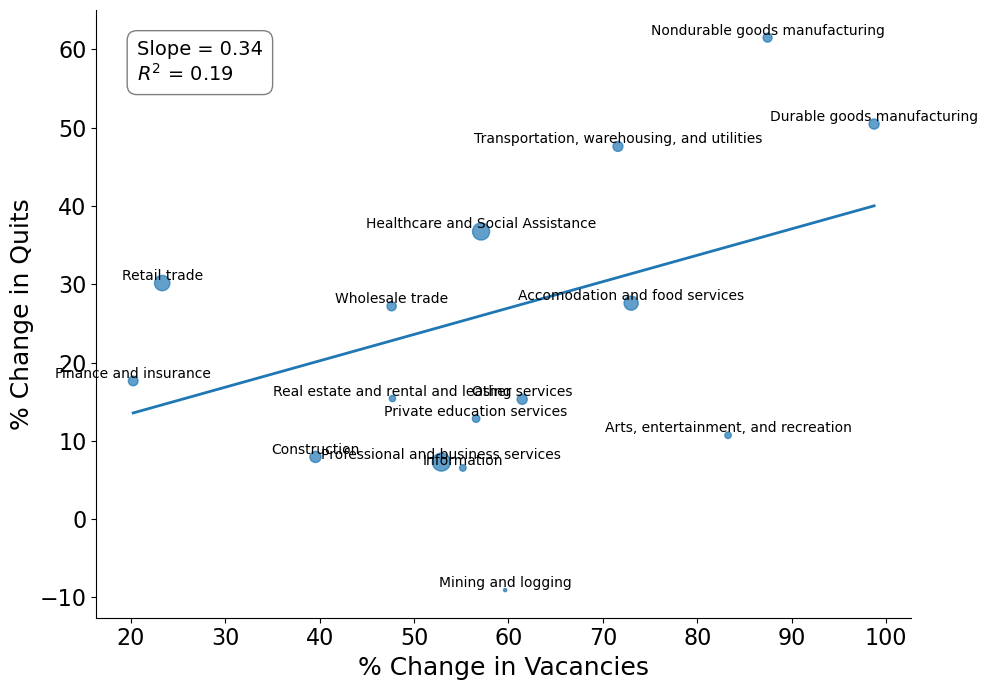

In [40]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up variables
x = final_df["job_opening_pct_change"].to_numpy(dtype=float)
y = final_df["quits_pct_change"].to_numpy(dtype=float)
weights = final_df["emp_share"].to_numpy(dtype=float)
industries = final_df["jolts_industry"]

# Fit weighted linear regression
X = sm.add_constant(x)
model = sm.WLS(y, X, weights=weights).fit()

# Regression results
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared

print(f"Intercept: {intercept:.2f}")
print(f"Slope (coefficient on job openings): {slope:.2f}")
print(f"R-squared: {r_squared:.2f}")

# Predicted line
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(sm.add_constant(x_pred))

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x, y, s=weights * 1000, alpha=0.7)

# Add labels for each industry
for i in range(len(final_df)):
    plt.text(x[i], y[i], industries.iloc[i], fontsize=10, ha='center', va='bottom')

# Regression line
plt.plot(x_pred, y_pred, linewidth=2)

# Axis labels and title
plt.xlabel("% Change in Vacancies", fontsize=18)
plt.ylabel("% Change in Quits", fontsize = 18)
#plt.title("Industry-Level % Changes: Quits vs Vacancies", fontsize=22)



# Add regression info with slope first, then R²
plt.text(0.05, 0.95,
         f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         fontsize=14, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5))

# Remove top and right spines to make it less boxy
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)


plt.tight_layout()
plt.savefig(f"{output_dir}/industry_flows_scatter.pdf")
plt.show()


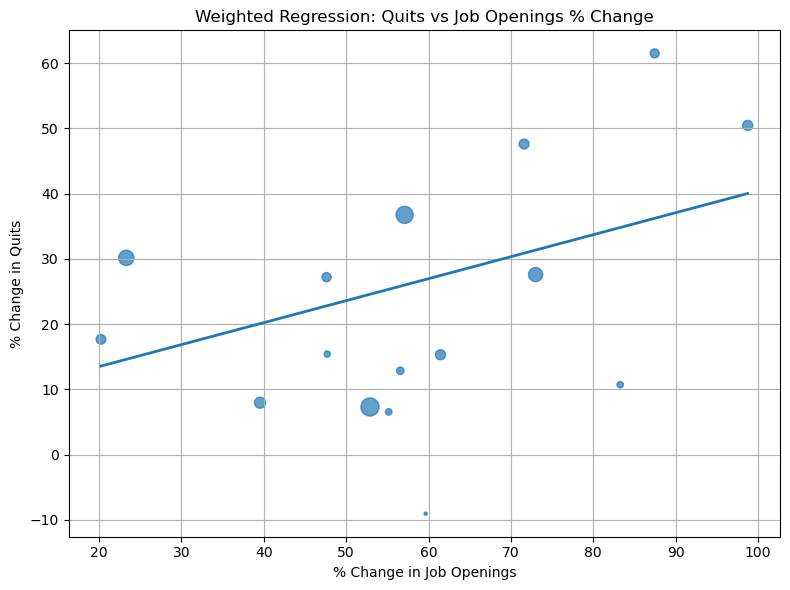

In [23]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set up variables
x = final_df["job_opening_pct_change"].to_numpy(dtype=float)
y = final_df["quits_pct_change"].to_numpy(dtype=float)
weights = final_df["emp_share"].to_numpy(dtype=float)


# Fit weighted linear regression
X = sm.add_constant(x)
model = sm.WLS(y, X, weights=weights).fit()

# Predicted line
x_pred = pd.Series(sorted(x))
y_pred = model.predict(sm.add_constant(x_pred))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=weights * 1000, alpha=0.7)
plt.plot(x_pred, y_pred, linewidth=2)
plt.xlabel("% Change in Job Openings")
plt.ylabel("% Change in Quits")
plt.title("Weighted Regression: Quits vs Job Openings % Change")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
x

array([72.99722534, 83.26322115, 39.55632383, 98.73756285, 20.2482603 ,
       57.10235068, 55.16990879, 59.65166909, 87.45038745, 61.45540834,
       56.57423971, 52.89452815, 47.7119895 , 23.3201581 , 71.60243408,
       47.62272903])

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse the fitted model and original X, y, weights from above
x_vals = pivot_df['pct_change_Job Openings']
y_vals = pivot_df['pct_change_Quits']
w = pivot_df['emp_share_Job Openings']

# Predict fitted values using the regression model
x_fit = np.linspace(x_vals.min(), x_vals.max(), 100)
X_fit = sm.add_constant(x_fit)
y_fit = model.predict(X_fit)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_vals, y_vals, s=w * 1000, alpha=0.6, label="Industries", edgecolor='k')
plt.plot(x_fit, y_fit, linewidth=2.5, label="Weighted Regression Line")
plt.xlabel("Pct Change in Job Openings")
plt.ylabel("Pct Change in Quits")
plt.title("Weighted Regression of Quits on Job Openings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'pct_change_Job Openings'

In [ ]:
import statsmodels.api as sm

# Prepare variables
x = df['Job Openings']
y = df['Quits']
w = df.drop_duplicates(subset='jolts_industry')['emp_share'].values  # or attach emp_share to `df` before

# Fit weighted regression
X = sm.add_constant(x)
model = sm.WLS(y, X, weights=w).fit()
x_pred = pd.Series(sorted(x))
y_pred = model.predict(sm.add_constant(x_pred))

# Plot with regression
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=w*1000, alpha=0.7)
plt.plot(x_pred, y_pred, color='red', label='Weighted Regression')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('% Change in Vacancies (inf vs pre)')
plt.ylabel('% Change in Quits (inf vs pre)')
plt.title('Industry-Level Changes: Vacancies vs Quits')

for _, row in df.iterrows():
    plt.text(row['Job Openings'], row['Quits'], row['jolts_industry'], fontsize=7)

plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/industry_flows_scatter.pdf")
plt.show()


KeyError: 'Job Openings'

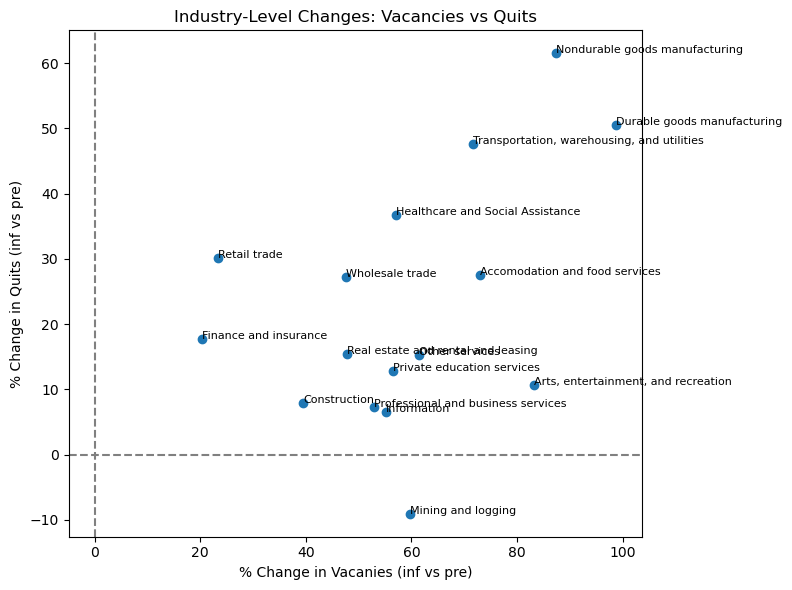

In [ ]:
# Pivot again to have one row per industry with two columns: job openings and quits
df = df.pivot(index='jolts_industry', columns='flow_type', values='pct_change').reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df['Job Openings'], df['Quits'])

# Add labels
for _, row in df.iterrows():
    plt.text(row['Job Openings'], row['Quits'], row['jolts_industry'], fontsize=8)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('% Change in Vacanies (inf vs pre)')
plt.ylabel('% Change in Quits (inf vs pre)')
plt.title('Industry-Level Changes: Vacancies vs Quits')
plt.tight_layout()
plt.savefig(f"{output_dir}/industry_flows_scatter.pdf")
plt.show()


C:\Users\singhy\AppData\Local\Temp\ipykernel_26200\2711817014.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]


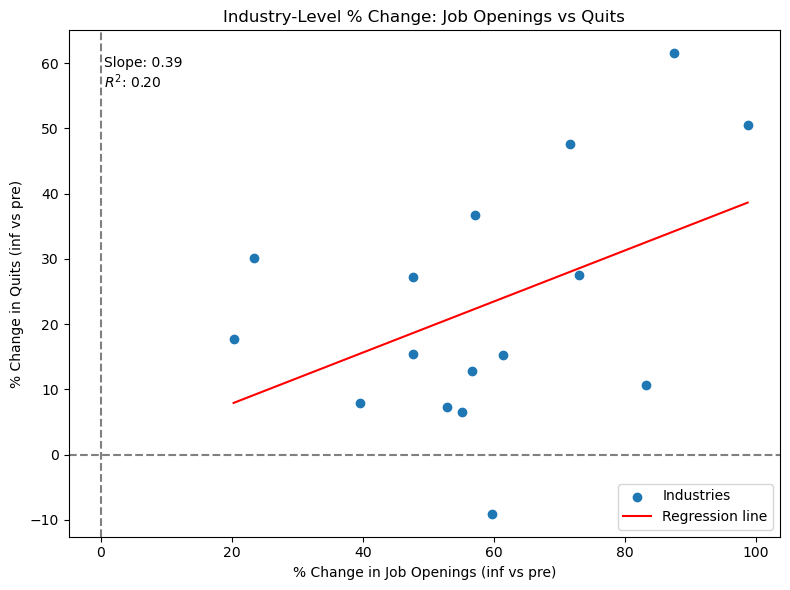

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Drop rows with missing or non-numeric values in either column
reg_df = df[['Job Openings', 'Quits']].copy()
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')  # force numeric conversion
reg_df = reg_df.dropna()

# Extract clean x and y
x = reg_df['Job Openings']
y = reg_df['Quits']

# Regress y on x
X = sm.add_constant(x)  # Add intercept
model = sm.OLS(y, X).fit()

# Predict values for regression line
x_pred = np.linspace(x.min(), x.max(), 100)
X_pred = sm.add_constant(x_pred)
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Industries')
plt.plot(x_pred, y_pred, color='red', label='Regression line')

# Add industry labels from the original df
for i, row in df.iterrows():
    if row['industry'] in reg_df.index:  # ensure label only for clean data
        plt.text(row['Job Openings'], row['Quits'], row['industry'], fontsize=8)

# Regression summary text
slope = model.params[1]
r_squared = model.rsquared
plt.text(0.05, 0.95,
         f"Slope: {slope:.2f}\n$R^2$: {r_squared:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('% Change in Job Openings (inf vs pre)')
plt.ylabel('% Change in Quits (inf vs pre)')
plt.title('Industry-Level % Change: Job Openings vs Quits')
plt.legend()
plt.tight_layout()
plt.show()

